In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import igraph as ig
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Prepraring tweets

In [2]:
tweets_df = pd.read_json("../../data/tweets.jl", lines=True, dtype=False)
users_df = pd.read_json('../../data/users.jl', lines=True, dtype=False)

In [3]:
tweets_df = tweets_df[(tweets_df["lang"] == "pl") & (tweets_df["in_reply_to_screen_name"].isnull())]

In [4]:
tweets_df['id'] = tweets_df['id_str']
tweets_df = tweets_df.merge(users_df[['id_str', 'screen_name']], how='left', right_on='id_str', left_on='user_id_str').drop(columns=['id_str_x', 'id_str_y'])
tweets_df = tweets_df.drop_duplicates(subset=['id'])

In [5]:
tweets_df["mentioned_users"] = tweets_df["full_text"].apply(lambda tweet: list(filter(lambda x: "@" in x, tweet.split(" "))))
tweets_df = tweets_df[tweets_df["mentioned_users"].str.len() != 0]
tweets_df["mentioned_users"] = tweets_df["mentioned_users"].apply(lambda users: list(map(lambda x: re.sub('[@:]', '', x), users)))

users = np.unique(np.concatenate([tweets_df["screen_name"].values]).tolist())

mentioned_users = np.unique(np.concatenate(tweets_df["mentioned_users"].values).tolist())
mentioned_users = list(filter(lambda x: x in users, mentioned_users))

In [6]:
tweets_df["mentioned_users"] = tweets_df["mentioned_users"].apply(lambda mentioned_users: list(filter(lambda x: x in users, mentioned_users)))
tweets_df = tweets_df[tweets_df["mentioned_users"].str.len() != 0]

### Plotting relation graph

In [7]:
popular_users_df = users_df[users_df["followers_count"] > 100_000]
popular_users =  popular_users_df["screen_name"].values.tolist()

In [8]:
users = tweets_df["screen_name"].unique().tolist()
users = list(filter(lambda x: x in popular_users, users))

In [9]:
g = ig.Graph()
g.add_vertices(len(users))
g.vs["user"] = users

edges = []
for _, row in tweets_df.iterrows():
  edges += [(row["screen_name"], user) for user in row["mentioned_users"]]
edges = [e for e in edges if e[0] != e[1] and e[0] in users and e[1] in users]
edges = [(users.index(e[0]), users.index(e[1])) for e in list(set(edges))]
g.add_edges(edges)

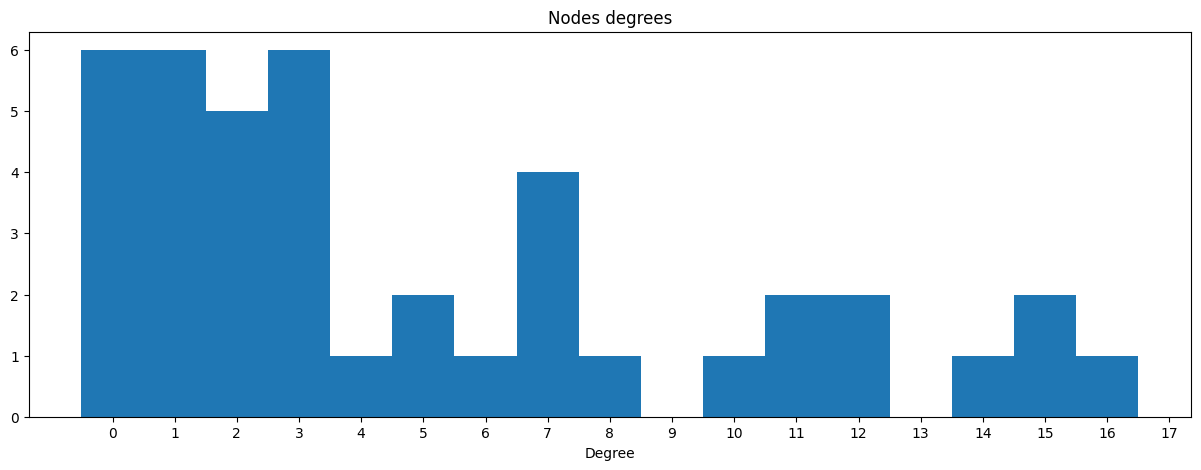

In [10]:
data = g.degree()
bins = np.arange(0, max(data) + 1.5) - 0.5
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.hist(data, bins)
ax.set_xticks(bins + 0.5)
ax.yaxis.get_major_locator().set_params(integer=True)

plt.title('Nodes degrees')
plt.xlabel('Degree')
plt.show()

In [11]:
# removing 0 degree nodes
to_delete_ids = [v.index for v in g.vs if v.degree() == 0]
g.delete_vertices(to_delete_ids)

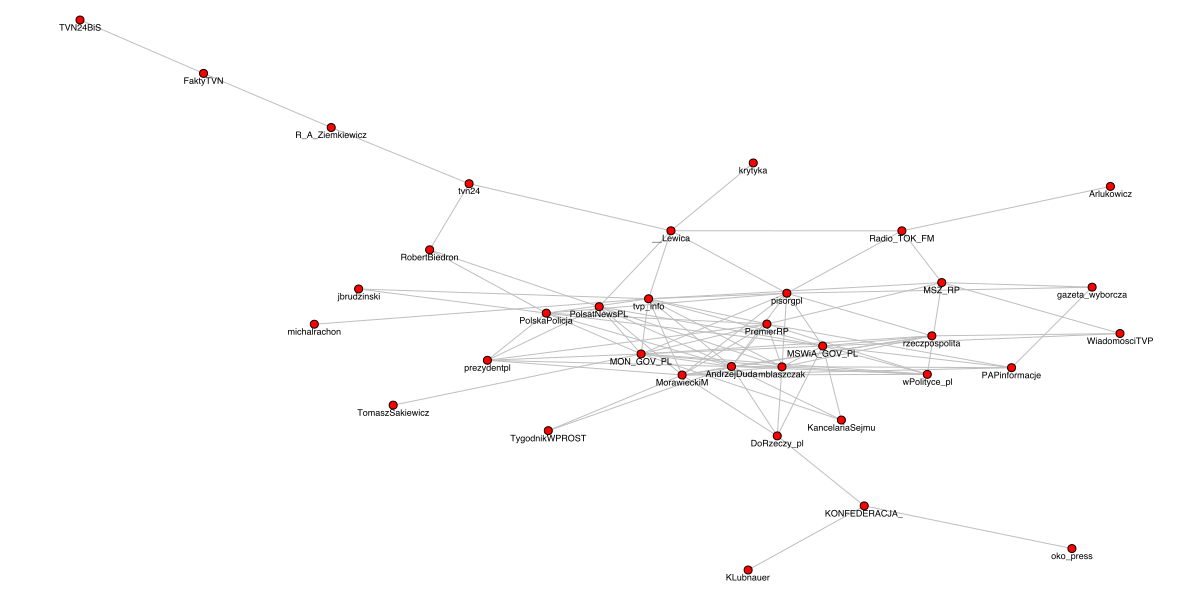

In [12]:
visual_style = {
    "vertex_size": 8,
    "vertex_label": g.vs["user"],
    "edge_color": "gray",
    "vertex_label_size": 9,
    "vertex_label_dist": 1,
    "margin": (80, 20, 80, 30),
    "bbox": (1200, 600)
}

g = g.simplify(multiple=True)
ig.plot(g, "./figures/popular_users_relation_graph.pdf", **visual_style)

Modularity: 0.26332409972299164
Community 0 -> Vertices: 7, edges: 8
Community 1 -> Vertices: 8, edges: 14
Community 2 -> Vertices: 4, edges: 3
Community 3 -> Vertices: 9, edges: 9
Community 4 -> Vertices: 7, edges: 14


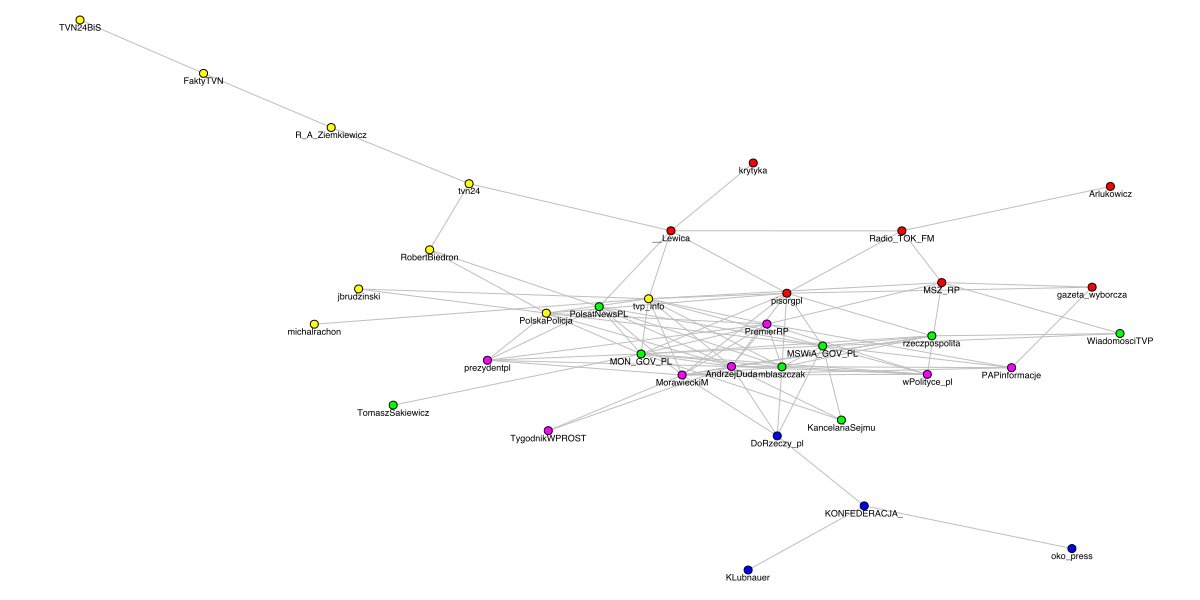

In [13]:
clusters = g.community_multilevel()
print(f"Modularity: {clusters.modularity}")
for i, community in enumerate(clusters.subgraphs()):
    print(f'Community {i} -> Vertices: {len(community.vs)}, edges: {len(community.es)}')
ig.plot(clusters, "./figures/clastered_popular_users_relation_graph.pdf", **visual_style)